In [1]:
import os
import matplotlib
import fiona
import geopandas as gp

import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as shPolygon

from tqdm import tqdm
from matplotlib import gridspec
from datetime import datetime, timedelta
from rasterio import features, mask
from IPython.display import HTML
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
def draw_polys(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True, zorder = 3):
    
    '''
    Turns a geopandas gdf of multipolygons into matplotlib polygon patches for friendly plotting with basemap. 
    '''
    
    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill, zorder = zorder)
        plt.gca().add_patch(poly)

    return


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True, zorder = 4):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 50
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor, zorder = zorder)


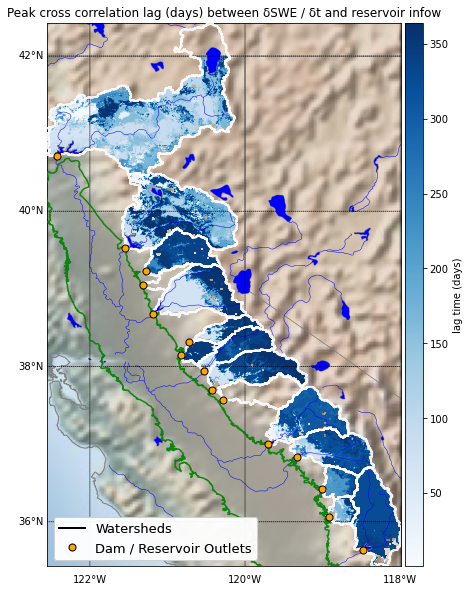

In [4]:
reservoirs = gp.read_file('../shape/term_res.shp')
catchments = gp.read_file('../shape/sierra_catchments.shp')
cv = gp.read_file('/Users/aakash/Desktop/HyDRA/shape/cv.shp')

src = rio.open("../rasters/SNODAS/snl.tif")
im = src.read(1)
im[im==0] = np.nan

# get bbox of data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(12,10))

# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot flowdir array 
im = m.imshow(np.flipud(im), cmap='Blues')
ax1.set_title("Peak cross correlation lag (days) between δSWE / δt and reservoir infow")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='lag time (days)')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

plt.show()